# Session 3 | Demo 3.2 - Fine-tuning vs. Prompting 

<a href="https://colab.research.google.com/github/dair-ai/maven-pe-for-llms/blob/main/notebooks/session-3/demo-3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The demo shows a comparison on fine-tuned results vs. few-shot learning and zero-shot learning results.

In [1]:
# load libraries
import openai
import os
import IPython
from langchain.llms import OpenAI
from dotenv import load_dotenv
import json

# load the environment variables
load_dotenv()

# set the OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
def set_open_params(
    model="text-davinci-003",
    temperature=0.7,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=""
):
    """ set openai parameters"""

    openai_params = {}    

    openai_params['model'] = model
    openai_params['temperature'] = temperature
    openai_params['max_tokens'] = max_tokens
    openai_params['top_p'] = top_p
    openai_params['frequency_penalty'] = frequency_penalty
    openai_params['presence_penalty'] = presence_penalty
    openai_params['stop'] = stop
    return openai_params

def get_completion(params, prompt):
    """ GET completion from openai api"""

    response = openai.Completion.create(
        engine = params['model'],
        prompt = prompt,
        temperature = params['temperature'],
        max_tokens = params['max_tokens'],
        top_p = params['top_p'],
        frequency_penalty = params['frequency_penalty'],
        presence_penalty = params['presence_penalty'],
        stop = params['stop']
    )
    return response

In [3]:
# basic example
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

prompt = "I am summer happy!\n\n###\n\n"

response = get_completion(params, prompt)

In [4]:
response

<OpenAIObject text_completion id=cmpl-7FUbhSyrKl1N7xXjQvJ3smqSzxvUS at 0x7f98721226d0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": " joy"
    }
  ],
  "created": 1683926929,
  "id": "cmpl-7FUbhSyrKl1N7xXjQvJ3smqSzxvUS",
  "model": "curie:ft-dair:emotionft-2023-04-19-23-24-21",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 9,
    "total_tokens": 10
  }
}

In [6]:
# basic example
params = set_open_params(model="text-davinci-003")

prompt = """
Your task is to classify a piece of text into either of the following labels: "anger", "fear", "joy", "love", "sadness", and "surprise".

Just output the label as a lowercase string.

Text: {text_input}
Output:
"""
response = get_completion(params, prompt.format(text_input="I am summer happy!"))

In [7]:
response

<OpenAIObject text_completion id=cmpl-7FUbvXgiaVVR4LRJazps2BsQA23Xm at 0x7f9870ca4540> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "joy"
    }
  ],
  "created": 1683926943,
  "id": "cmpl-7FUbvXgiaVVR4LRJazps2BsQA23Xm",
  "model": "text-davinci-003",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 65,
    "total_tokens": 66
  }
}

In [8]:
# import jsonl file and convert to Pandas dataframe   
import pandas as pd

df = pd.read_json("../data/merged_training_sample_100_prepared_valid.jsonl", lines=True)


In [9]:
df

,prompt,completion
0,i feel it has only been agitated by the presen...,fear\n
1,i thought as i can often feel the rather unple...,sadness\n
2,i can t hear her with all the other kids and m...,fear\n
3,i am sure i will feel this longing again when ...,love\n
4,i had been having sexual feelings and romantic...,love\n
...,...,...
115,i feel bashful discussing it i m a closet game...,fear\n
116,i was feeling agitated and giddy all at the sa...,fear\n
117,i feel restless though and know if i close my ...,fear\n
118,i report my feelings on the ex a movie about w...,fear\n


In [10]:
df.prompt.tolist()[0:5]

['i feel it has only been agitated by the presence of the smoking\n\n###\n\n',
 'i thought as i can often feel the rather unpleasant sensation of the babys head trying to stick out of my stomach up near my ribs\n\n###\n\n',
 'i can t hear her with all the other kids and mums and nannies around me no dads of course but i m so used to being the only dad in a sea of mums and nannies that it doesn t even feel weird any more\n\n###\n\n',
 'i am sure i will feel this longing again when i go visit my dear friend in the hospital and hold her new little boy in my arms but i will go home and hold my little girl and remember god has chosen this path for me for a reason and maybe one day i will be able to put this longing behind me\n\n###\n\n',
 'i had been having sexual feelings and romantic longings for years and unlike my straight peers i had kept it all bottled up\n\n###\n\n']

### Predictions from our fine-tuned model

In [11]:
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

prompt = "I am summer happy!\n\n###\n\n"

response = get_completion(params, df.prompt.tolist()[0:5])

In [13]:
# batch the prompts from df.prompt.tolist() into batches of 10
prompt_batches = [df.prompt.tolist()[i:i + 10] for i in range(0, len(df.prompt.tolist()), 10)]

In [15]:
params = set_open_params(model="curie:ft-dair:emotionft-2023-04-19-23-24-21", stop=["\n"])

finetuned_responses = []

for batch in prompt_batches:
    response = get_completion(params, batch)
    finetuned_responses.append([c.text.strip(" ") for c in response.choices])

In [16]:
df.completion[0:3], prompt_batches[0][0:3], finetuned_responses[0][0:3]

(0        fear\n
 1     sadness\n
 2        fear\n
 Name: completion, dtype: object,
 ['i feel it has only been agitated by the presence of the smoking\n\n###\n\n',
  'i thought as i can often feel the rather unpleasant sensation of the babys head trying to stick out of my stomach up near my ribs\n\n###\n\n',
  'i can t hear her with all the other kids and mums and nannies around me no dads of course but i m so used to being the only dad in a sea of mums and nannies that it doesn t even feel weird any more\n\n###\n\n'],
 ['fear', 'anger', 'surprise'])

### Predictions from GPT-3 Model

This prompt can be improved as it sometimes outputs other emotions like relief. the way i deal with this is be mapping it after I get the responses.

In [17]:
# zero-shot prompt
zeroshot_prompt = """
Your task is to classify a piece of text, delimited by triple backticks, into the following emotion labels: ["anger", "fear", "joy", "love", "sadness", "surprise"].

Just output the label as a lowercase string.

Text: ```{text_input}```
Output emotion label:
"""

In [20]:
# python double for loop comprehension list
promptified_prompts_batches = [[zeroshot_prompt.format(text_input=prompt.strip("\n\n###\n\n")) for prompt in batch] for batch in prompt_batches]

In [22]:
# ~15 seconds

params = set_open_params(model="text-davinci-003", temperature=0)

gpt3_responses = []

for batch in promptified_prompts_batches:
    response = get_completion(params, batch)
    gpt3_responses.append([c.text.strip("\n") for c in response.choices])

In [23]:
# flatten the list of lists
gpt3_responses_flat = [item for sublist in gpt3_responses for item in sublist]
finetuned_responses_flat = [item for sublist in finetuned_responses for item in sublist]

df["gpt3-completion"] = gpt3_responses_flat
df["finetuned-completion"] = finetuned_responses_flat

# fix the completion labels

df["completion"] = df["completion"].apply(lambda x: x.strip("\n").strip(" "))

In [24]:
# map "relief" to "sadness" for the gpt3-completion
df["gpt3-completion"] = df["gpt3-completion"].apply(lambda x: "sadness" if x == "relief" else x)

In [25]:
df["gpt3-completion"].unique()

array(['anger', 'sadness', 'love', 'surprise', 'joy', 'fear'],
      dtype=object)

In [26]:
df["finetuned-completion"].unique()

array(['fear', 'anger', 'surprise', 'love', 'joy', 'sadness'],
      dtype=object)

In [28]:
df

,prompt,completion,gpt3-completion,finetuned-completion
0,i feel it has only been agitated by the presen...,fear,anger,fear
1,i thought as i can often feel the rather unple...,sadness,sadness,anger
2,i can t hear her with all the other kids and m...,fear,sadness,surprise
3,i am sure i will feel this longing again when ...,love,love,love
4,i had been having sexual feelings and romantic...,love,sadness,love
...,...,...,...,...
115,i feel bashful discussing it i m a closet game...,fear,sadness,fear
116,i was feeling agitated and giddy all at the sa...,fear,surprise,fear
117,i feel restless though and know if i close my ...,fear,sadness,fear
118,i report my feelings on the ex a movie about w...,fear,sadness,fear


In [29]:
# write the dataframe to a pickle file
df.to_pickle("../data/finetuning-prompting-completions.pkl")

## Perform Evaluation / Analysis

In [2]:
import pandas as pd

# load the pickle file from ../data/finetuning-prompting-completions.pkl
df = pd.read_pickle("../data/finetuning-prompting-completions.pkl")

In [3]:
# map completion labels to integers
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

df["completion"] = df["completion"].map(completion_map)
df["gpt3-completion"] = df["gpt3-completion"].map(completion_map)
df["finetuned-completion"] = df["finetuned-completion"].map(completion_map)

In [4]:
# mapper back to string labels
completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise"
}

([<matplotlib.axis.YTick at 0x7fdbe8ac8f10>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

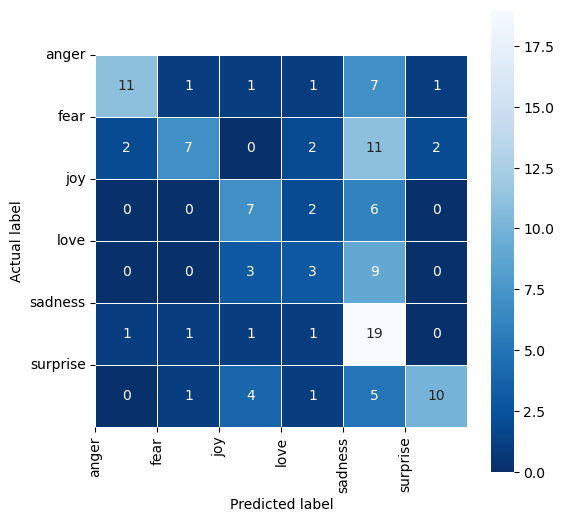

In [5]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df["completion"], df["gpt3-completion"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")


([<matplotlib.axis.YTick at 0x7fdbe8b268e0>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

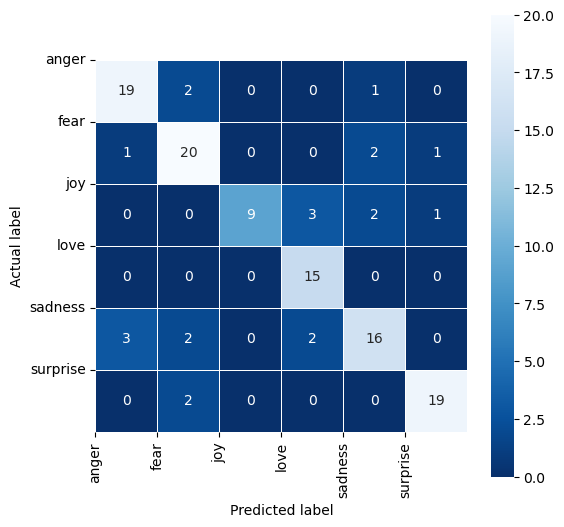

In [6]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df["completion"], df["finetuned-completion"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with emotion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

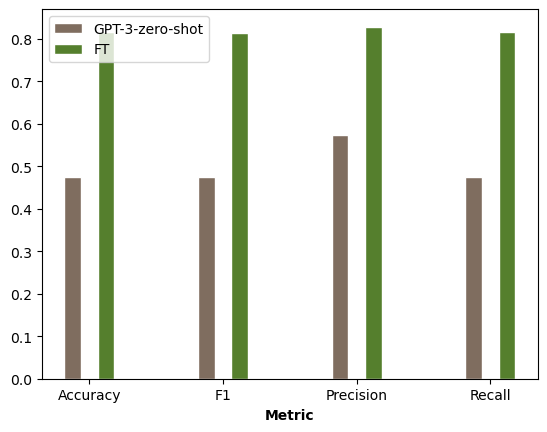

In [22]:
# use scikitlearn to calculate the accuracy score and other metrics like F1
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

gpt_3_acc = accuracy_score(df["completion"], df["gpt3-completion"])

gpt_3_f1 = f1_score(df["completion"], df["gpt3-completion"], average="weighted")

gpt_3_precision = precision_score(df["completion"], df["gpt3-completion"], average="weighted")

gpt_3_recall = recall_score(df["completion"], df["gpt3-completion"], average="weighted")

finetuned_acc = accuracy_score(df["completion"], df["finetuned-completion"])

finetuned_f1 = f1_score(df["completion"], df["finetuned-completion"], average="weighted")

finetuned_precision = precision_score(df["completion"], df["finetuned-completion"], average="weighted")

finetuned_recall = recall_score(df["completion"], df["finetuned-completion"], average="weighted")


# plot the accuracy, F1, precision, and recall scores in a bar chart
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.50

# set height of bar
bars1 = [gpt_3_acc, gpt_3_f1, gpt_3_precision, gpt_3_recall]

bars2 = [finetuned_acc, finetuned_f1, finetuned_precision, finetuned_recall]

# Set position of bar on X axis
r1 = [1, 5, 9, 13]
r2 = [2, 6, 10, 14]

# Make the plot
plt.bar(r1, bars1, color="#7f6d5f", width=barWidth, edgecolor="white", label="GPT-3-zero-shot")
plt.bar(r2, bars2, color="#557f2d", width=barWidth, edgecolor="white", label="FT")

# Add xticks on the middle of the group bars, make sure to correct the xticks
plt.xlabel("Metric", fontweight="bold")

# use r1 and r2 positions to set the xticks
plt.xticks([r1[r] + barWidth for r in range(len(bars1))], ["Accuracy", "F1", "Precision", "Recall"])


# Create legend & Show graphic
plt.legend()
plt.show()


In [23]:
gpt_3_acc, gpt_3_f1, gpt_3_precision, gpt_3_recall

(0.475, 0.4748244342539883, 0.5747393925518925, 0.475)

In [24]:
finetuned_acc, finetuned_f1, finetuned_precision, finetuned_recall

(0.8166666666666667,
 0.8134349446849447,
 0.8284105085735521,
 0.8166666666666667)